In [1]:
import os
import glob
import math
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# plotting
import matplotlib.pyplot as plt
import itertools

# xgboost for ensembling baseline
import xgboost as xgb

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

EEG_CSV = "./EEG_data.csv"
DEMO_CSV = "./demographic_info.csv"
VIDEOS_DIR = "./videos"
OUT_DIR = "./artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

T_TARGET = 120
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 40
USE_FOCAL_LOSS = True   
USE_AUGMENTATION = True      
ENSEMBLE_WITH_XGB = True     
XGB_ENSEMBLE_WEIGHT = 0.4     

# display utilities for showing saved images inline
from IPython.display import Image, display


In [2]:
# utilities 
def resample_to_fixed_np(arr, T_target=T_TARGET):
    """Resample 2D array arr (T, C) to T_target using linear interpolation (numpy only)."""
    T, C = arr.shape
    if T == T_target:
        return arr.astype(np.float32)
    x_old = np.linspace(0.0, 1.0, T)
    x_new = np.linspace(0.0, 1.0, T_target)
    out = np.zeros((T_target, C), dtype=np.float32)
    for ci in range(C):
        out[:, ci] = np.interp(x_new, x_old, arr[:, ci])
    return out

# load CSVs 
eeg_df = pd.read_csv(EEG_CSV)
demo_df = pd.read_csv(DEMO_CSV) if os.path.exists(DEMO_CSV) else pd.DataFrame()
print('EEG rows:', len(eeg_df))
print('Demographics rows:', len(demo_df))
print('EEG columns:', eeg_df.columns.tolist())
print('Demo columns:', demo_df.columns.tolist())

GROUP_COLS = ['SubjectID', 'VideoID']
# detect label columns
col_map = {}
for c in eeg_df.columns:
    low = c.lower().replace('-', '').replace('_', '')
    if 'predefinedlabel' in low:
        col_map['predefinedlabel'] = c
    if 'userdefinedlabeln' in low:
        col_map['user_defined'] = c

if 'predefinedlabel' not in col_map and 'user_defined' not in col_map:
    raise ValueError(f"Could not detect label columns automatically. Found: {col_map}. Please check EEG CSV headers.")
print('Detected label cols:', col_map)

# feature cols exclude group and label cols
exclude = set(GROUP_COLS) | set(col_map.values())
FEATURE_COLS = [c for c in eeg_df.columns if c not in exclude]
print('Feature cols:', FEATURE_COLS)

EEG rows: 12811
Demographics rows: 10
EEG columns: ['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'predefinedlabel', 'user-definedlabeln']
Demo columns: ['SubjectID', 'age', 'ethnicity', 'gender']
Detected label cols: {'predefinedlabel': 'predefinedlabel', 'user_defined': 'user-definedlabeln'}
Feature cols: ['Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']


In [3]:
# group into trials 
sample_dict = OrderedDict()
labels_pre = {}
labels_user = {}
for (sub, vid), g in eeg_df.groupby(GROUP_COLS):
    arr = g[FEATURE_COLS].values.astype(np.float32)
    arr = resample_to_fixed_np(arr, T_target=T_TARGET)
    key = (int(sub), str(vid))
    sample_dict[key] = arr
    row = g.iloc[0]
    # prefer user label if exists else predefined
    if 'user_defined' in col_map:
        labels_user[key] = int(row[col_map['user_defined']])
    else:
        labels_user[key] = int(row[col_map.get('predefinedlabel')])
    labels_pre[key] = int(row[col_map.get('predefinedlabel')]) if 'predefinedlabel' in col_map else labels_user[key]

print('Samples grouped:', len(sample_dict))

Samples grouped: 100


In [4]:
# demographics processing 
if len(demo_df) > 0 and 'SubjectID' in demo_df.columns:
    demo_df = demo_df.set_index('SubjectID')
# safe columns
demo_cat_cols = [c for c in ['ethnicity', 'gender'] if c in demo_df.columns]
if len(demo_cat_cols) == 0 or demo_df.shape[0] == 0:
    demo_onehot = pd.DataFrame(np.zeros((len(sample_dict), 1)), index=[k[0] for k in sample_dict.keys()], columns=['demo_dummy'])
else:
    demo_onehot = pd.get_dummies(demo_df[demo_cat_cols].fillna('Unknown'))
    if 'age' in demo_df.columns:
        demo_onehot['age'] = (demo_df['age'] - demo_df['age'].mean()) / (demo_df['age'].std() + 1e-8)

# ensure int index for demo_onehot
try:
    demo_onehot.index = demo_onehot.index.astype(int)
except Exception:
    # if demo missing or non-int, create empty/dummy mapped by subject in sample_dict
    pass
demo_onehot.to_csv(os.path.join(OUT_DIR, 'demo_vectors.csv'))
print('Demo vector shape:', demo_onehot.shape)

Demo vector shape: (10, 6)


In [5]:
# video embeddings (cache per-video as mean embeddings)
VIDEO_EMB_DIR = os.path.join(OUT_DIR, 'video_embeddings')
os.makedirs(VIDEO_EMB_DIR, exist_ok=True)

# canonical video ids from sample_dict
video_ids = sorted({ str(int(float(vid))) if str(vid).replace('.0','').isdigit() or str(vid).replace('.','').isdigit() else str(vid) for (_, vid) in sample_dict.keys() })
print('Found video ids (from EEG):', video_ids)

# try init resnet
USE_RESNET = True
IMG_SIZE = (224,224)
try:
    resnet = keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg')
    preprocess = keras.applications.resnet50.preprocess_input
except Exception as e:
    print('ResNet init failed:', e)
    USE_RESNET = False

video_emb_dict = {}
if USE_RESNET:
    for vid in tqdm(video_ids, desc='video->emb'):
        out_path = os.path.join(VIDEO_EMB_DIR, f'{vid}.npy')
        if os.path.exists(out_path):
            video_emb_dict[vid] = np.load(out_path)
            continue
        # find file
        matches = []
        for ext in ['m4v','mp4','mov','avi','mkv']:
            p = os.path.join(VIDEOS_DIR, f"{vid}.{ext}")
            if os.path.exists(p):
                matches.append(p)
        if not matches:
            g = glob.glob(os.path.join(VIDEOS_DIR, f"{vid}.*"))
            matches = g
        if not matches:
            print('Video not found for', vid, '- using zero embedding')
            # zero embedding fallback
            dim = resnet.output_shape[-1] if USE_RESNET else 2048
            video_emb_dict[vid] = np.zeros((dim,), dtype=np.float32)
            continue
        video_file = matches[0]
        # extract frames -- fewer frames if memory/time constrained
        def extract_frames_from_video(path, num_frames=30, start_sec=30, duration=60):
            cap = cv2.VideoCapture(path)
            if not cap.isOpened():
                return []
            fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
            start_frame = int(start_sec * fps)
            end_frame = int((start_sec + duration) * fps)
            start_frame = max(0, min(start_frame, max(total_frames-1, 0)))
            end_frame = max(0, min(end_frame, max(total_frames-1, 0)))
            if end_frame <= start_frame:
                start_frame = 0
                end_frame = max(total_frames-1, 0)
            frame_indices = np.linspace(start_frame, end_frame, num_frames).astype(int)
            frames = []
            for fi in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, int(fi))
                ret, frame = cap.read()
                if not ret or frame is None:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, IMG_SIZE)
                frames.append(frame)
            cap.release()
            return frames

        frames = extract_frames_from_video(video_file, num_frames=20, start_sec=10, duration=30)
        if len(frames) == 0:
            print('No frames for', vid, '— using zero embedding')
            video_emb_dict[vid] = np.zeros((resnet.output_shape[-1],), dtype=np.float32)
            continue
        x = np.stack(frames).astype(np.float32)
        x = preprocess(x)
        emb = resnet.predict(x, verbose=0)
        emb_mean = emb.mean(axis=0)
        np.save(out_path, emb_mean)
        video_emb_dict[vid] = emb_mean
else:
    dim = 2048
    for vid in video_ids:
        video_emb_dict[vid] = np.zeros((dim,), dtype=np.float32)

video_dim = next(iter(video_emb_dict.values())).shape[0]
print('video_dim:', video_dim)

Found video ids (from EEG): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


video->emb: 100%|██████████| 10/10 [00:00<00:00, 3368.11it/s]

video_dim: 2048


In [6]:
# prepare keys, subjects, labels arrays 
all_keys = list(sample_dict.keys())
subjects = np.array([k[0] for k in all_keys])
labels_arr = np.array([labels_user[k] for k in all_keys])

# augmentation helper
def augment_eeg(arr):
    """Simple augmentation: small gaussian noise, channel dropout, time masking."""
    a = arr.copy()
    # gaussian noise
    a = a + np.random.normal(0, 0.01, a.shape).astype(np.float32)
    # channel dropout
    if np.random.rand() < 0.2:
        ci = np.random.randint(0, a.shape[1])
        a[:,ci] = 0
    # time masking
    if np.random.rand() < 0.2:
        t = a.shape[0]
        w = int(t * 0.1)
        if w>0:
            s = np.random.randint(0, t - w + 1)
            a[s:s+w,:] = 0
    return a

In [7]:
# dataset builder with optional augmentation and sample weights support 
def compute_sample_weights_for_keys(keys, class_weight_map):
    labels = np.array([labels_user[k] for k in keys]).astype(np.int32)
    sample_weights = np.array([class_weight_map[int(lbl)] for lbl in labels], dtype=np.float32)
    return sample_weights

def make_dataset_from_keys(keys, sample_weights=None, shuffle=True, batch_size=BATCH_SIZE, augment=False):
    eeg_list = []
    video_list = []
    demo_list = []
    label_list = []
    sw_list = [] if sample_weights is not None else None
    for idx,k in enumerate(keys):
        sub, vid = k
        arr = sample_dict[k].astype(np.float32)
        # augmentation only for training (augment True)
        if augment and USE_AUGMENTATION:
            arr = augment_eeg(arr)
        # per-trial z-score normalization (prevent divide by 0)
        mean = arr.mean(axis=0, keepdims=True)
        std = arr.std(axis=0, keepdims=True) + 1e-8
        arr = (arr - mean) / std
        eeg_list.append(arr)
        # normalize vid key to canonical
        try:
            vid_norm = str(int(float(vid)))
        except Exception:
            vid_norm = str(vid)
        v_emb = video_emb_dict.get(vid_norm, np.zeros((video_dim,), dtype=np.float32))
        video_list.append(v_emb)
        if sub in demo_onehot.index:
            demo_list.append(demo_onehot.loc[sub].values.astype(np.float32))
        else:
            demo_list.append(np.zeros((demo_onehot.shape[1],), dtype=np.float32))
        label_list.append(labels_user[k])
        if sample_weights is not None:
            sw_list.append(float(sample_weights[idx]))

    eeg_arr = np.stack(eeg_list)
    video_arr = np.stack(video_list)
    demo_arr = np.stack(demo_list)
    label_arr = np.array(label_list).astype(np.float32)
    dummy_att = np.zeros((len(label_arr), 3), dtype=np.float32)

    if sample_weights is None:
        ds = tf.data.Dataset.from_tensor_slices(((eeg_arr, video_arr, demo_arr), (label_arr, dummy_att)))
    else:
        sw = np.array(sw_list, dtype=np.float32)
        ds = tf.data.Dataset.from_tensor_slices(((eeg_arr, video_arr, demo_arr), (label_arr, dummy_att), sw))

    if shuffle:
        ds = ds.shuffle(128, seed=SEED)
    # if sample weights provided, include them in dataset as third element
    if sample_weights is None:
        ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    else:
        # dataset yields ((X...), (y...)), sample_weight
        ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

In [8]:
class TCNBlock(layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, dropout=0.2, kernel_regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout = dropout
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        in_channels = int(input_shape[-1])
        self.conv1 = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size,
                                   padding='causal', dilation_rate=self.dilation_rate,
                                   kernel_regularizer=self.kernel_regularizer)
        self.act1 = layers.ReLU()
        self.drop1 = layers.Dropout(self.dropout)

        self.conv2 = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size,
                                   padding='causal', dilation_rate=self.dilation_rate,
                                   kernel_regularizer=self.kernel_regularizer)
        self.act2 = layers.ReLU()
        self.drop2 = layers.Dropout(self.dropout)

        if in_channels != self.filters:
            self.downsample = layers.Conv1D(self.filters, 1, padding='same')
        else:
            self.downsample = None
        super().build(input_shape)

    def call(self, x, training=False):
        y = self.conv1(x)
        y = self.act1(y)
        y = self.drop1(y, training=training)
        y = self.conv2(y)
        y = self.act2(y)
        y = self.drop2(y, training=training)
        res = x if self.downsample is None else self.downsample(x)
        return tf.nn.relu(y + res)

def build_tcn_encoder(input_length=T_TARGET, input_channels=None, num_levels=4, base_filters=32, kernel_size=5):
    inp = layers.Input((input_length, input_channels), name='eeg_input')
    x = inp
    filters = base_filters
    for i in range(num_levels):
        x = TCNBlock(filters=filters, kernel_size=kernel_size, dilation_rate=2**i,
                     dropout=0.3, kernel_regularizer=keras.regularizers.l2(1e-4))(x)
        filters = min(filters * 2, 256)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(192, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    return keras.Model(inp, x, name='tcn_encoder')

def build_demo_encoder(input_dim, out_dim=32):
    inp = layers.Input((input_dim,), name='demo_input')
    x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(out_dim, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    return keras.Model(inp, x, name='demo_encoder')

class AttTemperature(layers.Layer):
    def __init__(self, init_val=1.0, **kwargs):
        super().__init__(**kwargs)
        self.init_val = init_val
    def build(self, input_shape):
        self.temp = self.add_weight(shape=(), initializer=keras.initializers.Constant(self.init_val),
                                    trainable=True, name='att_temp')
        super().build(input_shape)
    def call(self, x):
        return x / (tf.abs(self.temp) + 1e-6)

def build_fusion_models(eeg_encoder, video_dim, demo_dim, hidden=256):
    eeg_in = eeg_encoder.input
    video_in = layers.Input(shape=(video_dim,), name='video_input')
    demo_in = layers.Input(shape=(demo_dim,), name='demo_input')

    eeg_feat = eeg_encoder(eeg_in)  # (B,128)
    video_proj = layers.Dense(128, activation='relu', name='video_proj')(video_in)
    demo_proj = layers.Dense(128, activation='relu', name='demo_proj')(demo_in)

    eeg_feat = layers.LayerNormalization(name='ln_eeg')(eeg_feat)
    video_proj = layers.LayerNormalization(name='ln_video')(video_proj)
    demo_proj = layers.LayerNormalization(name='ln_demo')(demo_proj)

    e_exp = layers.Reshape((1, 128))(eeg_feat)
    v_exp = layers.Reshape((1, 128))(video_proj)
    d_exp = layers.Reshape((1, 128))(demo_proj)
    modalities = layers.Concatenate(axis=1, name='modalities_stack')([e_exp, v_exp, d_exp])  # (B,3,128)

    modalities_normed = layers.LayerNormalization(name='ln_modalities')(modalities)
    att_hidden = layers.TimeDistributed(layers.Dense(64, activation='relu'), name='att_dense1')(modalities_normed)
    att_logits = layers.TimeDistributed(layers.Dense(1), name='att_logits')(att_hidden)
    att_logits_squeezed = layers.Reshape((3,))(att_logits)
    att_logits_scaled = AttTemperature()(att_logits_squeezed)
    att_weights = layers.Activation('softmax', name='att_weights')(att_logits_scaled)  # (B,3)
    att_weights_exp = layers.Reshape((3,1))(att_weights)

    weighted = layers.Multiply(name='weighted_modalities')([modalities, att_weights_exp])
    fused = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1), name='fused')(weighted)

    x = layers.Dense(hidden, activation='relu', name='fusion_fc1', kernel_regularizer=keras.regularizers.l2(1e-4))(fused)
    x = layers.Dropout(0.4)(x)
    logits = layers.Dense(1, name='logits')(x)
    prob = layers.Activation('sigmoid', name='prob')(logits)

    model_full = keras.Model(inputs=[eeg_in, video_in, demo_in], outputs=[prob, att_weights], name='fusion_full')
    return model_full

In [9]:
# instantiate encoders
input_channels = len(FEATURE_COLS)
eeg_encoder = build_tcn_encoder(input_length=T_TARGET, input_channels=input_channels, num_levels=4, base_filters=32, kernel_size=5)
demo_dim = demo_onehot.shape[1]
print('eeg_encoder output shape:', eeg_encoder.output_shape)
print('demo_dim', demo_dim)

model_full = build_fusion_models(eeg_encoder, video_dim=video_dim, demo_dim=demo_dim, hidden=256)

# === focal loss implementation (if enabled) ===
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        y_true = tf.cast(y_true, tf.float32)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1-alpha)
        loss = - alpha_t * tf.pow(1. - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    return loss_fn

prob_loss = focal_loss(alpha=0.25, gamma=2.0) if USE_FOCAL_LOSS else 'binary_crossentropy'

model_full.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                   loss={'prob': prob_loss, 'att_weights': 'mse'},
                   loss_weights={'prob': 1.0, 'att_weights': 0.0},
                   metrics={'prob': ['accuracy']})

model_full.summary()


eeg_encoder output shape: (None, 128)
demo_dim 6


Model: "fusion_full"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ eeg_input           │ (None, 120, 11)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ video_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demo_input          │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn_encoder         │ (None, 128)       │    770,848 │ eeg_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ video_proj (Dense)  │ (None, 128)       │    262,272 │ video_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demo_proj (Dense)   │ (None, 128)       │        896 │ demo_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_eeg              │ (None, 128)       │        256 │ tcn_encoder[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_video            │ (None, 128)       │        256 │ video_proj[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_demo             │ (None, 128)       │        256 │ demo_proj[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ ln_eeg[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 128)    │          0 │ ln_video[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 128)    │          0 │ ln_demo[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ modalities_stack    │ (None, 3, 128)    │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ reshape_1[0][0],  │
│                     │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_modalities       │ (None, 3, 128)    │        256 │ modalities_stack… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_dense1          │ (None, 3, 64)     │      8,256 │ ln_modalities[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_logits          │ (None, 3, 1)      │         65 │ att_dense1[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 3)         │          0 │ att_logits[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_temperature     │ (None, 3)         │          1 │ reshape_3[0][0]   │
│ (AttTemperature)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,076,643 (4.11 MB)

 Trainable params: 1,076,643 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# === XGBoost helper: aggregate simple stats per-trial and train XGB ===
def build_aggregated_features_dict(sample_dict, FEATURE_COLS):
    """Return X_agg (N,D) and keys list for order."""
    keys = list(sample_dict.keys())
    feats = []
    for k in keys:
        arr = sample_dict[k]  # T x C
        mean = arr.mean(axis=0)
        std = arr.std(axis=0)
        q25 = np.percentile(arr, 25, axis=0)
        q50 = np.percentile(arr, 50, axis=0)
        q75 = np.percentile(arr, 75, axis=0)
        feat = np.concatenate([mean, std, q25, q50, q75])
        feats.append(feat)
    X = np.stack(feats)
    return keys, X

agg_keys, X_agg_all = build_aggregated_features_dict(sample_dict, FEATURE_COLS)
y_agg_all = np.array([labels_user[k] for k in agg_keys])

def train_xgb_on_keys(train_keys, val_keys):
    # map keys to indices in agg_keys
    key_to_idx = {k: i for i,k in enumerate(agg_keys)}
    train_idx = [key_to_idx[k] for k in train_keys]
    val_idx = [key_to_idx[k] for k in val_keys]
    X_train = X_agg_all[train_idx]
    y_train = y_agg_all[train_idx]
    X_val = X_agg_all[val_idx]
    y_val = y_agg_all[val_idx]
    clf = xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    clf.fit(X_train, y_train)
    p_val = clf.predict_proba(X_val)[:,1]
    return clf, p_val

n_subjects (LOSO folds): 10

=== Fold 0 ===
class_weight (per-class): {0: 1.0227272727272727, 1: 0.9782608695652174}
Epoch 1/40


c:\Users\Mandar Garud\Desktop\confused-student\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:05:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  -> epoch 0 val_best_f1: 0.6667 at t=0.10
12/12 - 8s - 661ms/step - att_weights_loss: 0.1560 - loss: 0.2815 - prob_accuracy: 0.4333 - prob_loss: 0.1418 - val_att_weights_loss: 0.2072 - val_loss: 0.2242 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0919 - learning_rate: 1.0000e-04
Epoch 2/40
  -> epoch 1 val_best_f1: 0.6667 at t=0.10
12/12 - 1s - 42ms/step - att_weights_loss: 0.1641 - loss: 0.2258 - prob_accuracy: 0.4333 - prob_loss: 0.0887 - val_att_weights_loss: 0.1509 - val_loss: 0.2022 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0695 - learning_rate: 1.0000e-04
Epoch 3/40
  -> epoch 2 val_best_f1: 0.6667 at t=0.10
12/12 - 0s - 32ms/step - att_weights_loss: 0.1643 - loss: 0.2093 - prob_accuracy: 0.5333 - prob_loss: 0.0753 - val_att_weights_loss: 0.1510 - val_loss: 0.2029 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0683 - learning_rate: 1.0000e-04
Epoch 4/40
  -> epoch 3 val_best_f1: 0.7143 at t=0.40
12/12 - 0s - 40ms/step - att_weights_loss: 0.1637 - loss: 0.2164 - prob_accur

c:\Users\Mandar Garud\Desktop\confused-student\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:05:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  -> epoch 0 val_best_f1: 0.5714 at t=0.10
12/12 - 2s - 195ms/step - att_weights_loss: 0.1481 - loss: 0.2086 - prob_accuracy: 0.5000 - prob_loss: 0.0805 - val_att_weights_loss: 0.1633 - val_loss: 0.2089 - val_prob_accuracy: 0.6000 - val_prob_loss: 0.1035 - learning_rate: 1.0000e-04
Epoch 2/40
  -> epoch 1 val_best_f1: 0.5714 at t=0.10
12/12 - 1s - 49ms/step - att_weights_loss: 0.1447 - loss: 0.2013 - prob_accuracy: 0.5222 - prob_loss: 0.0713 - val_att_weights_loss: 0.1498 - val_loss: 0.2073 - val_prob_accuracy: 0.6000 - val_prob_loss: 0.0977 - learning_rate: 1.0000e-04
Epoch 3/40
  -> epoch 2 val_best_f1: 0.5714 at t=0.10
12/12 - 1s - 46ms/step - att_weights_loss: 0.1503 - loss: 0.2079 - prob_accuracy: 0.5333 - prob_loss: 0.0849 - val_att_weights_loss: 0.1536 - val_loss: 0.2062 - val_prob_accuracy: 0.6000 - val_prob_loss: 0.0919 - learning_rate: 1.0000e-04
Epoch 4/40
  -> epoch 3 val_best_f1: 0.5714 at t=0.10
12/12 - 1s - 50ms/step - att_weights_loss: 0.1456 - loss: 0.1962 - prob_accur

c:\Users\Mandar Garud\Desktop\confused-student\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:05:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  -> epoch 0 val_best_f1: 0.7500 at t=0.10
12/12 - 2s - 183ms/step - att_weights_loss: 0.1271 - loss: 0.1924 - prob_accuracy: 0.6000 - prob_loss: 0.0716 - val_att_weights_loss: 0.1285 - val_loss: 0.1969 - val_prob_accuracy: 0.4000 - val_prob_loss: 0.0709 - learning_rate: 1.0000e-04
Epoch 2/40
  -> epoch 1 val_best_f1: 0.8000 at t=0.30
12/12 - 0s - 35ms/step - att_weights_loss: 0.1314 - loss: 0.1913 - prob_accuracy: 0.5556 - prob_loss: 0.0696 - val_att_weights_loss: 0.1295 - val_loss: 0.1984 - val_prob_accuracy: 0.4000 - val_prob_loss: 0.0707 - learning_rate: 1.0000e-04
Epoch 3/40
  -> epoch 2 val_best_f1: 0.8000 at t=0.30
12/12 - 0s - 34ms/step - att_weights_loss: 0.1400 - loss: 0.1860 - prob_accuracy: 0.6111 - prob_loss: 0.0713 - val_att_weights_loss: 0.1432 - val_loss: 0.1995 - val_prob_accuracy: 0.4000 - val_prob_loss: 0.0713 - learning_rate: 1.0000e-04
Epoch 4/40
  -> epoch 3 val_best_f1: 0.8000 at t=0.30
12/12 - 0s - 34ms/step - att_weights_loss: 0.1461 - loss: 0.1911 - prob_accur

c:\Users\Mandar Garud\Desktop\confused-student\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Epoch 1/40
  -> epoch 0 val_best_f1: 0.7273 at t=0.40
12/12 - 2s - 187ms/step - att_weights_loss: 0.1428 - loss: 0.1804 - prob_accuracy: 0.6333 - prob_loss: 0.0683 - val_att_weights_loss: 0.1465 - val_loss: 0.1818 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0585 - learning_rate: 1.0000e-04
Epoch 2/40
  -> epoch 1 val_best_f1: 0.7692 at t=0.30
12/12 - 1s - 46ms/step - att_weights_loss: 0.1489 - loss: 0.1819 - prob_accuracy: 0.5778 - prob_loss: 0.0684 - val_att_weights_loss: 0.1475 - val_loss: 0.1829 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0575 - learning_rate: 1.0000e-04
Epoch 3/40
  -> epoch 2 val_best_f1: 0.6667 at t=0.10
12/12 - 0s - 35ms/step - att_weights_loss: 0.1542 - loss: 0.1762 - prob_accuracy: 0.6111 - prob_loss: 0.0678 - val_att_weights_loss: 0.1492 - val_loss: 0.1851 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0606 - learning_rate: 1.0000e-04
Epoch 4/40
  -> epoch 3 val_best_f1: 0.7692 at t=0.30
12/12 - 1s - 47ms/step - att_weights_loss: 0.1508 - loss: 0.1739 -

c:\Users\Mandar Garud\Desktop\confused-student\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  -> epoch 0 val_best_f1: 0.9231 at t=0.40
12/12 - 2s - 182ms/step - att_weights_loss: 0.1452 - loss: 0.1724 - prob_accuracy: 0.6111 - prob_loss: 0.0665 - val_att_weights_loss: 0.1516 - val_loss: 0.1562 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0440 - learning_rate: 1.0000e-04
Epoch 2/40
  -> epoch 1 val_best_f1: 0.9231 at t=0.35
12/12 - 0s - 38ms/step - att_weights_loss: 0.1448 - loss: 0.1716 - prob_accuracy: 0.6556 - prob_loss: 0.0643 - val_att_weights_loss: 0.1591 - val_loss: 0.1594 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0517 - learning_rate: 1.0000e-04
Epoch 3/40
  -> epoch 2 val_best_f1: 0.9231 at t=0.35
12/12 - 0s - 37ms/step - att_weights_loss: 0.1595 - loss: 0.1692 - prob_accuracy: 0.6000 - prob_loss: 0.0646 - val_att_weights_loss: 0.1649 - val_loss: 0.1642 - val_prob_accuracy: 0.4000 - val_prob_loss: 0.0574 - learning_rate: 1.0000e-04
Epoch 4/40
  -> epoch 3 val_best_f1: 0.8571 at t=0.35
12/12 - 0s - 35ms/step - att_weights_loss: 0.1575 - loss: 0.1730 - prob_accur

c:\Users\Mandar Garud\Desktop\confused-student\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  -> epoch 0 val_best_f1: 0.9091 at t=0.55
12/12 - 2s - 188ms/step - att_weights_loss: 0.1482 - loss: 0.1724 - prob_accuracy: 0.5556 - prob_loss: 0.0653 - val_att_weights_loss: 0.1672 - val_loss: 0.1530 - val_prob_accuracy: 0.7000 - val_prob_loss: 0.0366 - learning_rate: 1.0000e-04
Epoch 2/40
  -> epoch 1 val_best_f1: 0.9231 at t=0.50
12/12 - 0s - 39ms/step - att_weights_loss: 0.1495 - loss: 0.1728 - prob_accuracy: 0.6000 - prob_loss: 0.0689 - val_att_weights_loss: 0.1656 - val_loss: 0.1533 - val_prob_accuracy: 0.9000 - val_prob_loss: 0.0376 - learning_rate: 1.0000e-04
Epoch 3/40
  -> epoch 2 val_best_f1: 0.9231 at t=0.45
12/12 - 1s - 47ms/step - att_weights_loss: 0.1507 - loss: 0.1682 - prob_accuracy: 0.5444 - prob_loss: 0.0675 - val_att_weights_loss: 0.1617 - val_loss: 0.1455 - val_prob_accuracy: 0.8000 - val_prob_loss: 0.0349 - learning_rate: 1.0000e-04
Epoch 4/40
  -> epoch 3 val_best_f1: 0.9231 at t=0.50
12/12 - 0s - 38ms/step - att_weights_loss: 0.1432 - loss: 0.1655 - prob_accur

c:\Users\Mandar Garud\Desktop\confused-student\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Epoch 1/40
  -> epoch 0 val_best_f1: 0.7692 at t=0.30
12/12 - 2s - 192ms/step - att_weights_loss: 0.1478 - loss: 0.1523 - prob_accuracy: 0.6222 - prob_loss: 0.0558 - val_att_weights_loss: 0.1563 - val_loss: 0.1475 - val_prob_accuracy: 0.7000 - val_prob_loss: 0.0581 - learning_rate: 2.5000e-05
Epoch 2/40
  -> epoch 1 val_best_f1: 0.7692 at t=0.30
12/12 - 0s - 39ms/step - att_weights_loss: 0.1516 - loss: 0.1597 - prob_accuracy: 0.6111 - prob_loss: 0.0617 - val_att_weights_loss: 0.1539 - val_loss: 0.1478 - val_prob_accuracy: 0.7000 - val_prob_loss: 0.0595 - learning_rate: 2.5000e-05
Epoch 3/40
  -> epoch 2 val_best_f1: 0.7692 at t=0.30
12/12 - 0s - 40ms/step - att_weights_loss: 0.1534 - loss: 0.1519 - prob_accuracy: 0.6667 - prob_loss: 0.0532 - val_att_weights_loss: 0.1548 - val_loss: 0.1482 - val_prob_accuracy: 0.7000 - val_prob_loss: 0.0610 - learning_rate: 2.5000e-05
Epoch 4/40
  -> epoch 3 val_best_f1: 0.7692 at t=0.30
12/12 - 0s - 37ms/step - att_weights_loss: 0.1535 - loss: 0.1547 -

c:\Users\Mandar Garud\Desktop\confused-student\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  -> epoch 0 val_best_f1: 1.0000 at t=0.35
12/12 - 2s - 205ms/step - att_weights_loss: 0.1483 - loss: 0.1609 - prob_accuracy: 0.5778 - prob_loss: 0.0624 - val_att_weights_loss: 0.1689 - val_loss: 0.1266 - val_prob_accuracy: 0.8000 - val_prob_loss: 0.0263 - learning_rate: 2.5000e-05
Epoch 2/40
  -> epoch 1 val_best_f1: 1.0000 at t=0.35
12/12 - 1s - 50ms/step - att_weights_loss: 0.1473 - loss: 0.1574 - prob_accuracy: 0.6556 - prob_loss: 0.0643 - val_att_weights_loss: 0.1658 - val_loss: 0.1265 - val_prob_accuracy: 0.8000 - val_prob_loss: 0.0268 - learning_rate: 2.5000e-05
Epoch 3/40
  -> epoch 2 val_best_f1: 1.0000 at t=0.35
12/12 - 0s - 38ms/step - att_weights_loss: 0.1488 - loss: 0.1521 - prob_accuracy: 0.6333 - prob_loss: 0.0538 - val_att_weights_loss: 0.1684 - val_loss: 0.1268 - val_prob_accuracy: 0.8000 - val_prob_loss: 0.0276 - learning_rate: 2.5000e-05
Epoch 4/40
  -> epoch 3 val_best_f1: 1.0000 at t=0.35
12/12 - 0s - 38ms/step - att_weights_loss: 0.1500 - loss: 0.1623 - prob_accur

c:\Users\Mandar Garud\Desktop\confused-student\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:06:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Epoch 1/40
  -> epoch 0 val_best_f1: 0.8571 at t=0.45
12/12 - 2s - 196ms/step - att_weights_loss: 0.1496 - loss: 0.1531 - prob_accuracy: 0.6333 - prob_loss: 0.0541 - val_att_weights_loss: 0.1576 - val_loss: 0.1458 - val_prob_accuracy: 0.8000 - val_prob_loss: 0.0478 - learning_rate: 2.5000e-05
Epoch 2/40
  -> epoch 1 val_best_f1: 0.8571 at t=0.45
12/12 - 0s - 38ms/step - att_weights_loss: 0.1482 - loss: 0.1523 - prob_accuracy: 0.6556 - prob_loss: 0.0559 - val_att_weights_loss: 0.1584 - val_loss: 0.1458 - val_prob_accuracy: 0.8000 - val_prob_loss: 0.0475 - learning_rate: 2.5000e-05
Epoch 3/40
  -> epoch 2 val_best_f1: 0.8571 at t=0.45
12/12 - 0s - 37ms/step - att_weights_loss: 0.1512 - loss: 0.1529 - prob_accuracy: 0.6667 - prob_loss: 0.0538 - val_att_weights_loss: 0.1582 - val_loss: 0.1468 - val_prob_accuracy: 0.8000 - val_prob_loss: 0.0495 - learning_rate: 2.5000e-05
Epoch 4/40
  -> epoch 3 val_best_f1: 1.0000 at t=0.45
12/12 - 0s - 37ms/step - att_weights_loss: 0.1505 - loss: 0.1553 -

c:\Users\Mandar Garud\Desktop\confused-student\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:07:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  -> epoch 0 val_best_f1: 0.7692 at t=0.35
12/12 - 2s - 188ms/step - att_weights_loss: 0.1503 - loss: 0.1500 - prob_accuracy: 0.7000 - prob_loss: 0.0528 - val_att_weights_loss: 0.1584 - val_loss: 0.1616 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0548 - learning_rate: 2.5000e-05
Epoch 2/40
  -> epoch 1 val_best_f1: 0.8333 at t=0.35
12/12 - 1s - 53ms/step - att_weights_loss: 0.1516 - loss: 0.1574 - prob_accuracy: 0.5889 - prob_loss: 0.0591 - val_att_weights_loss: 0.1599 - val_loss: 0.1613 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0549 - learning_rate: 2.5000e-05
Epoch 3/40
  -> epoch 2 val_best_f1: 0.7692 at t=0.35
12/12 - 1s - 50ms/step - att_weights_loss: 0.1542 - loss: 0.1568 - prob_accuracy: 0.6667 - prob_loss: 0.0589 - val_att_weights_loss: 0.1602 - val_loss: 0.1612 - val_prob_accuracy: 0.5000 - val_prob_loss: 0.0551 - learning_rate: 2.5000e-05
Epoch 4/40
  -> epoch 3 val_best_f1: 0.8333 at t=0.35
12/12 - 0s - 38ms/step - att_weights_loss: 0.1515 - loss: 0.1574 - prob_accur

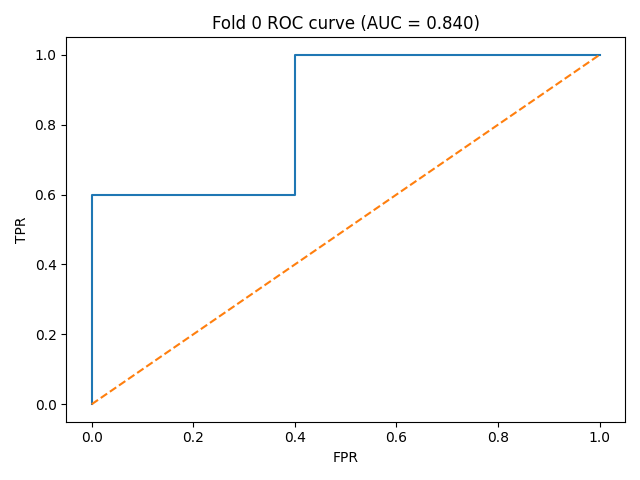

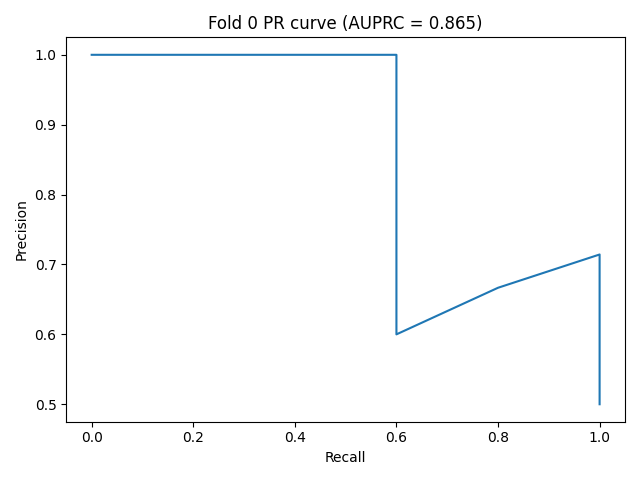

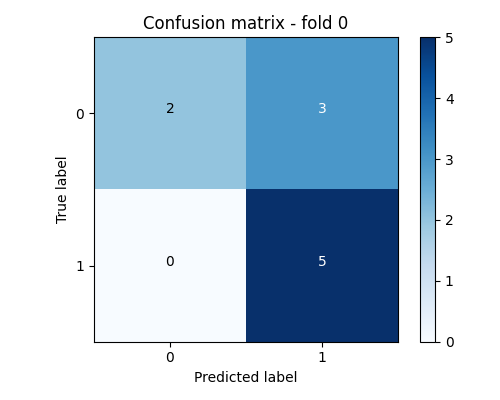

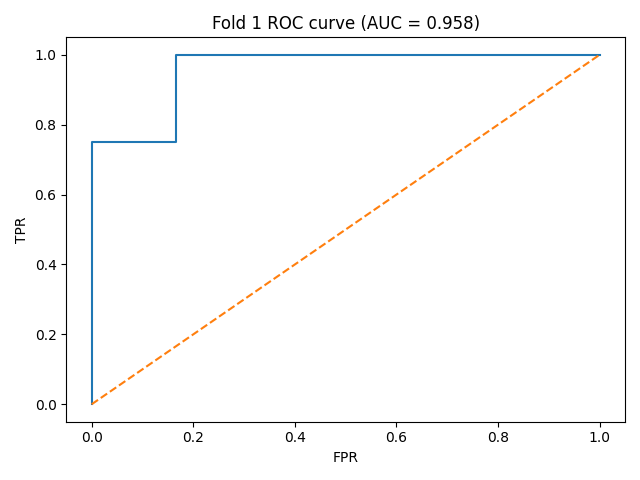

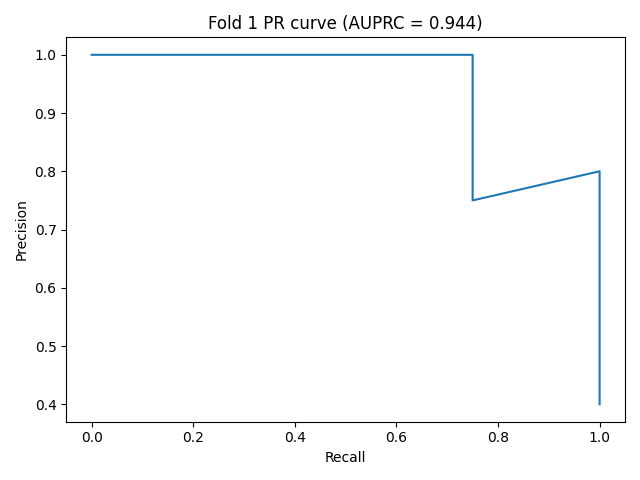

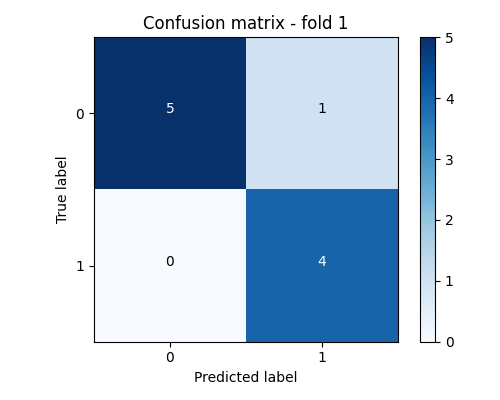

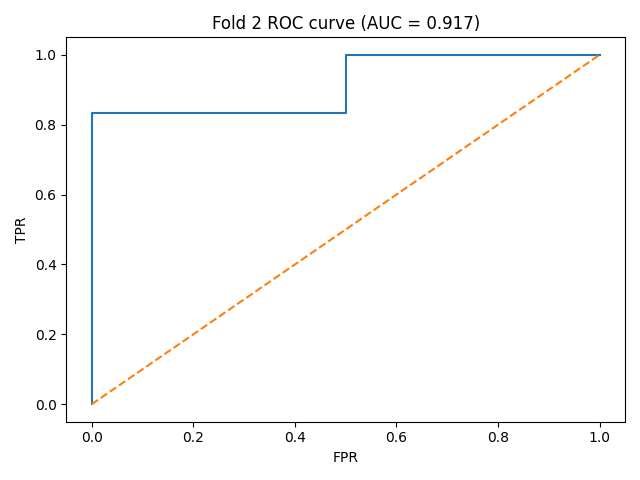

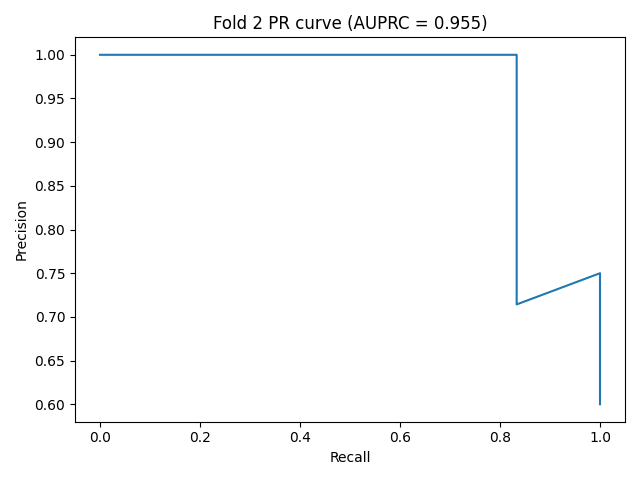

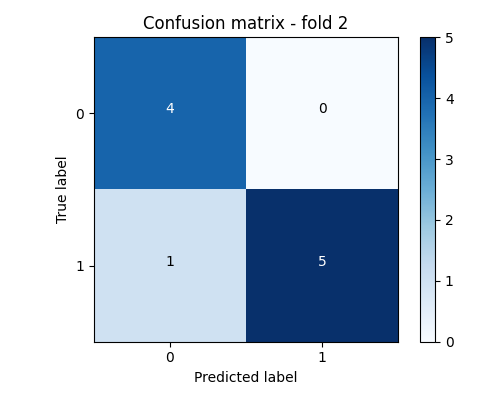

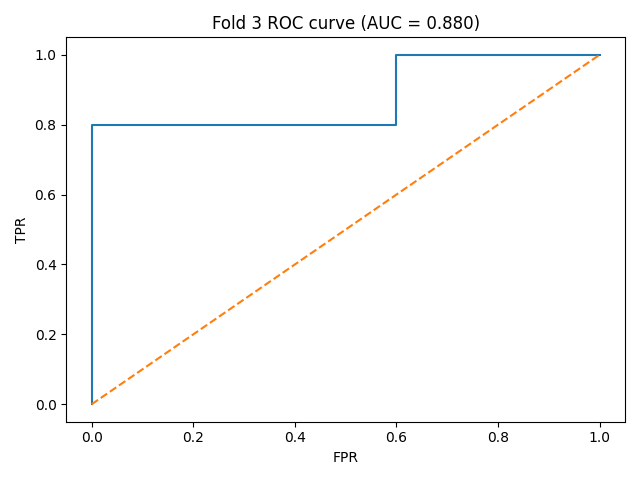

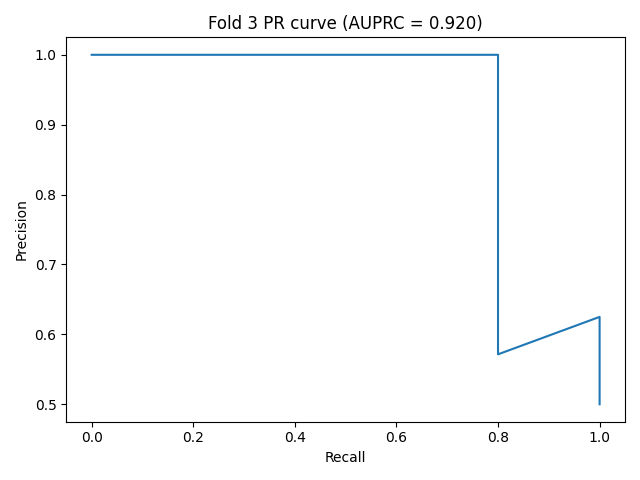

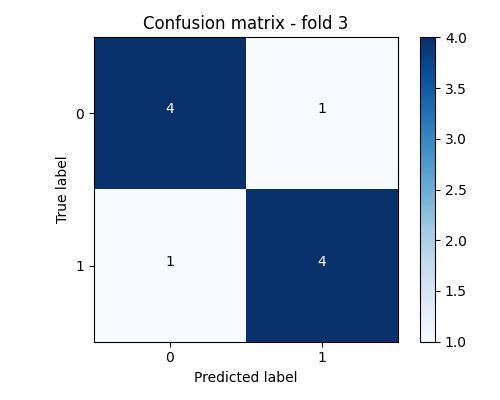

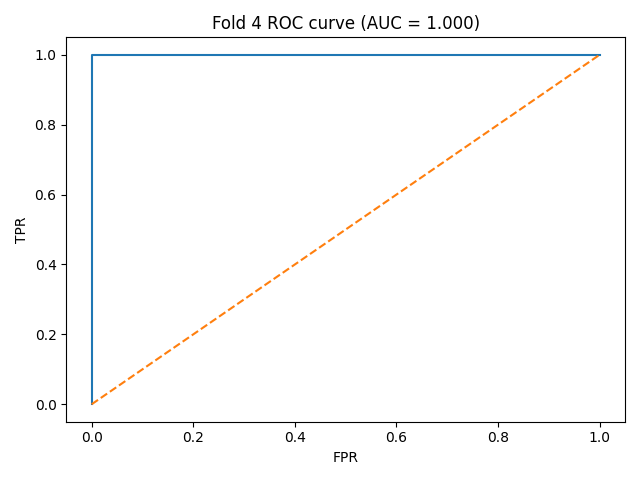

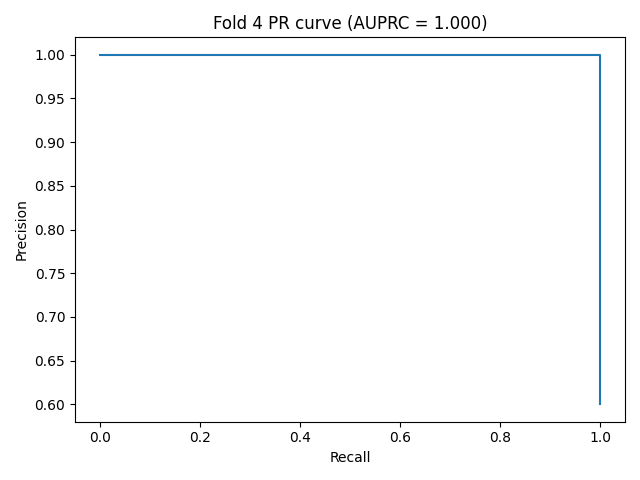

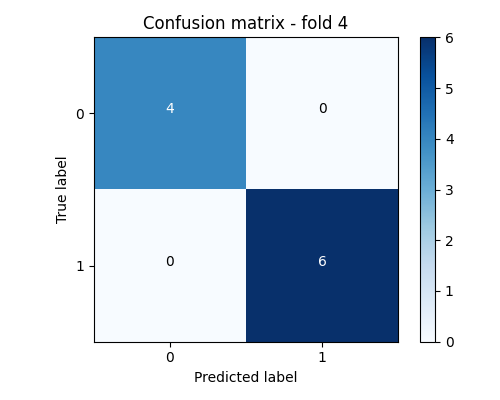

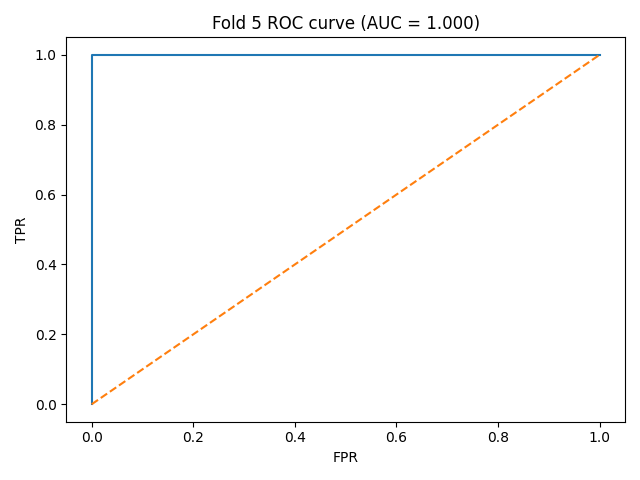

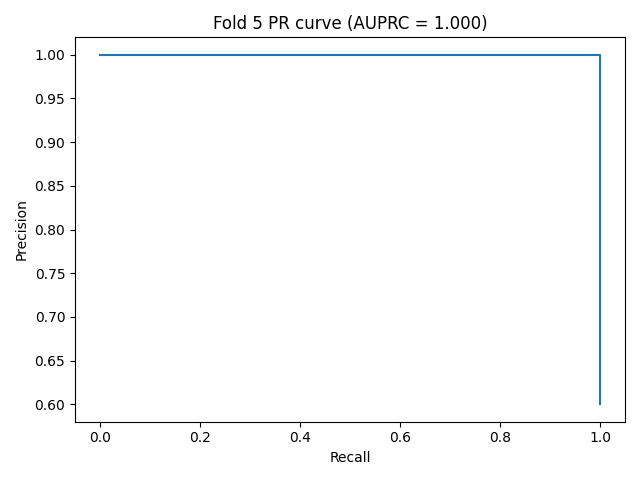

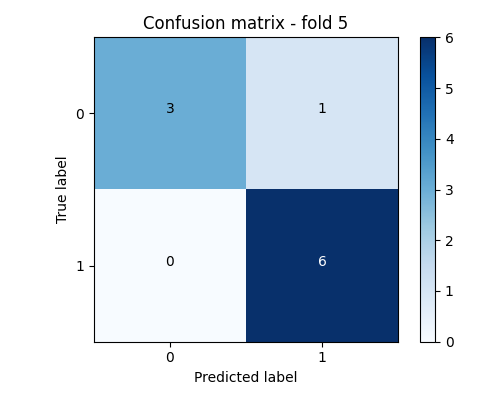

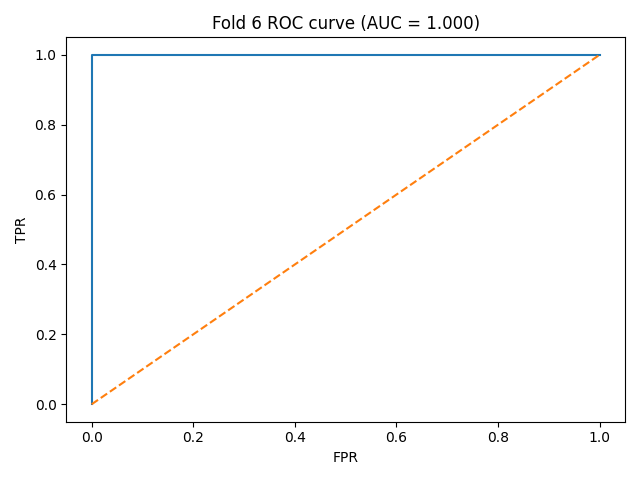

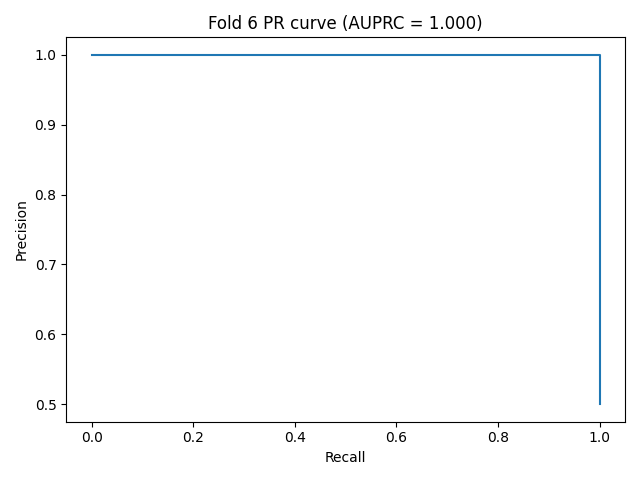

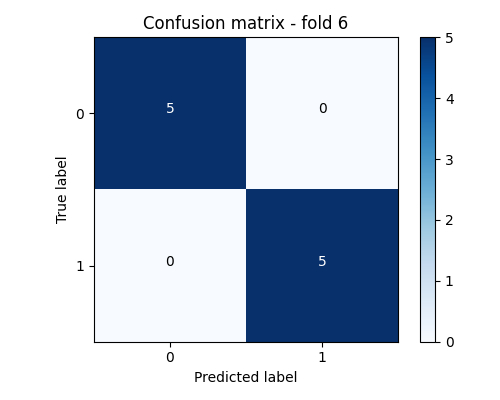

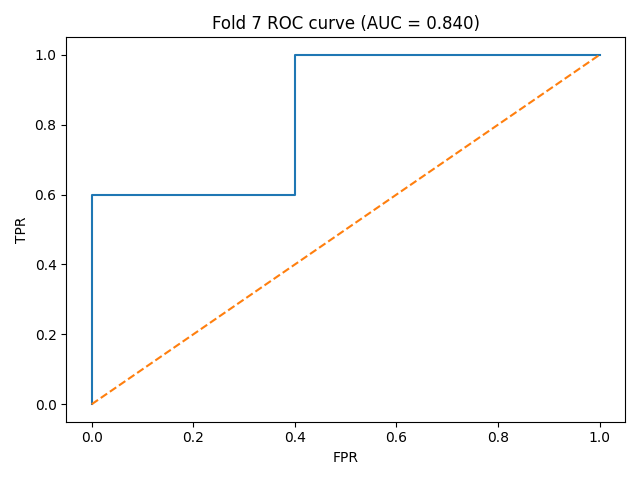

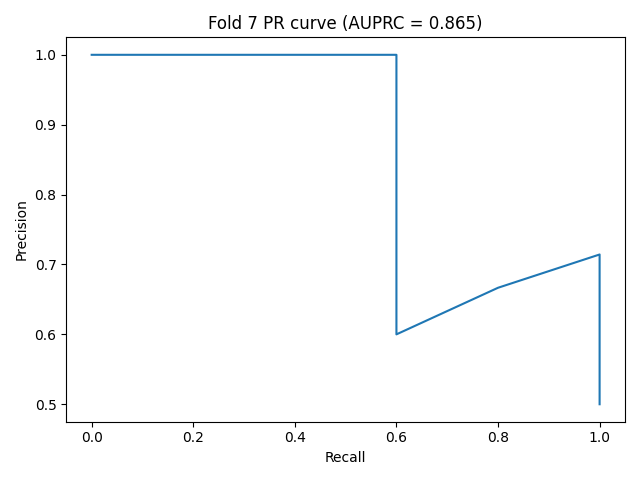

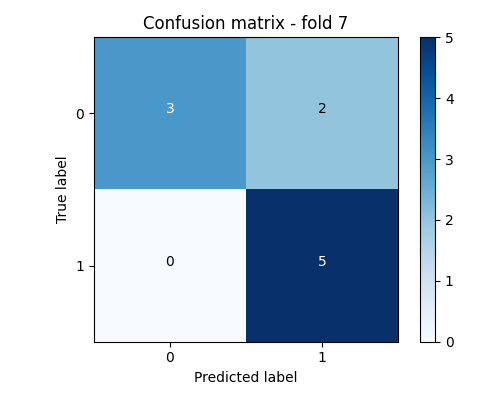

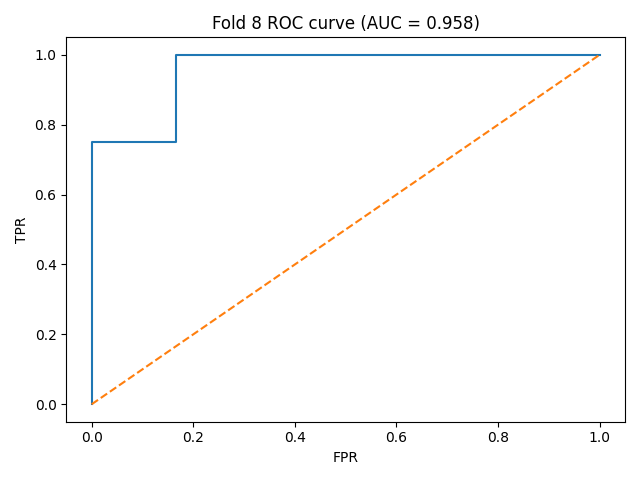

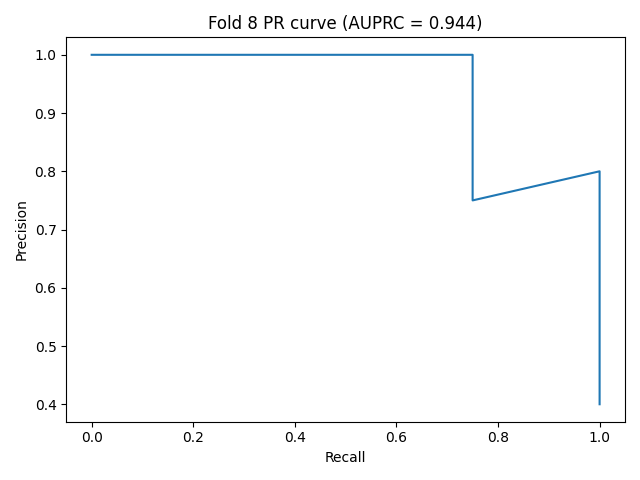

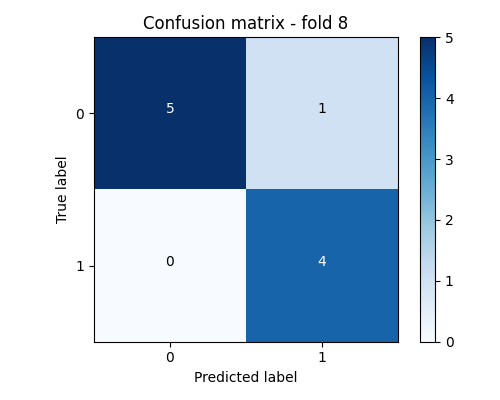

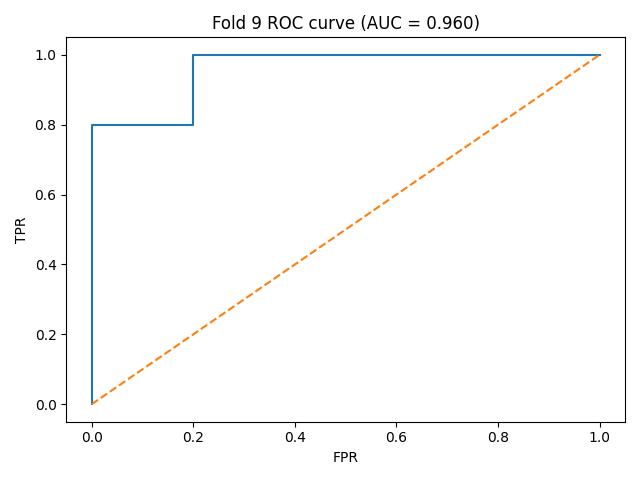

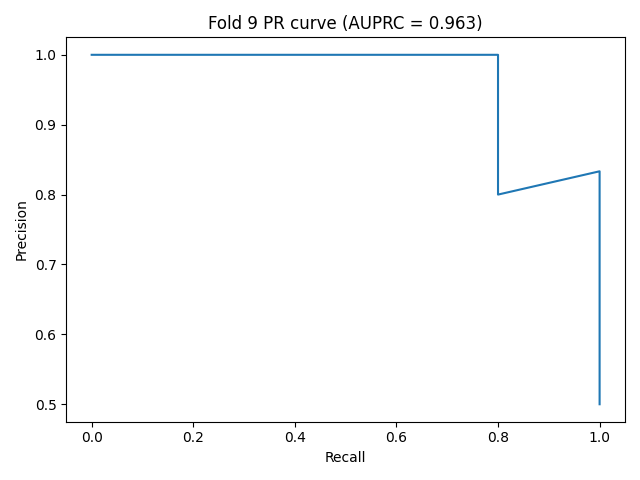

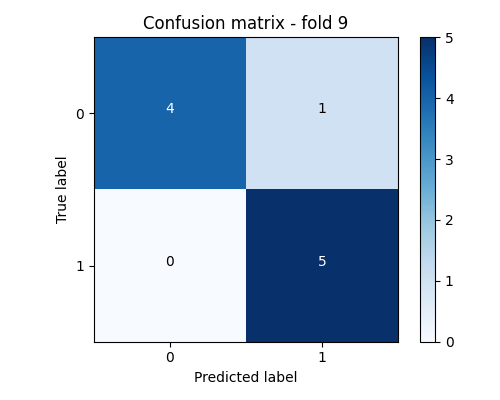

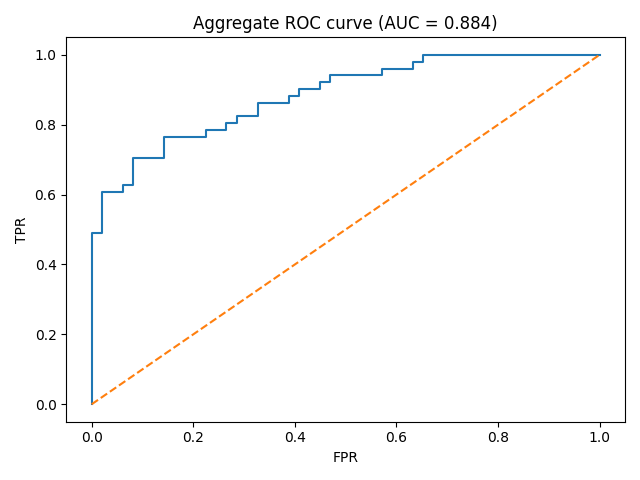

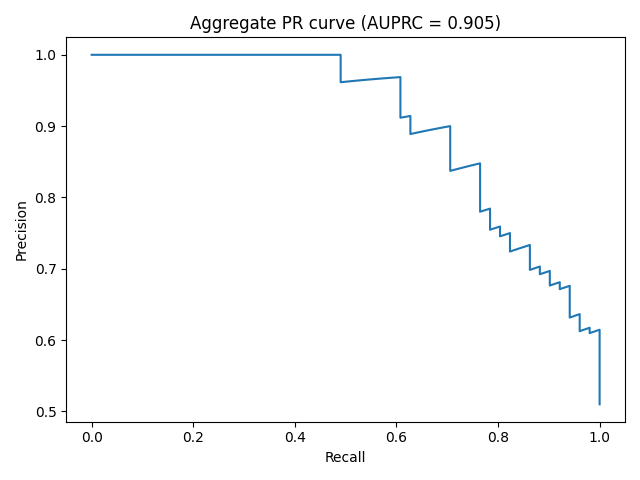

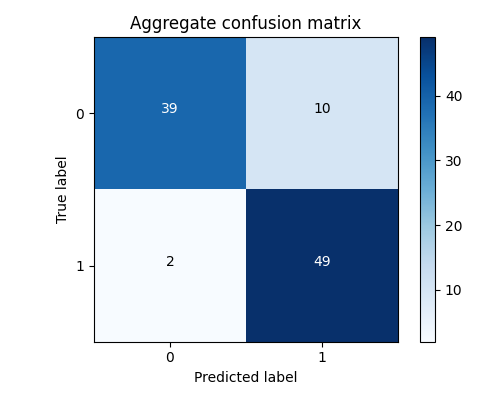

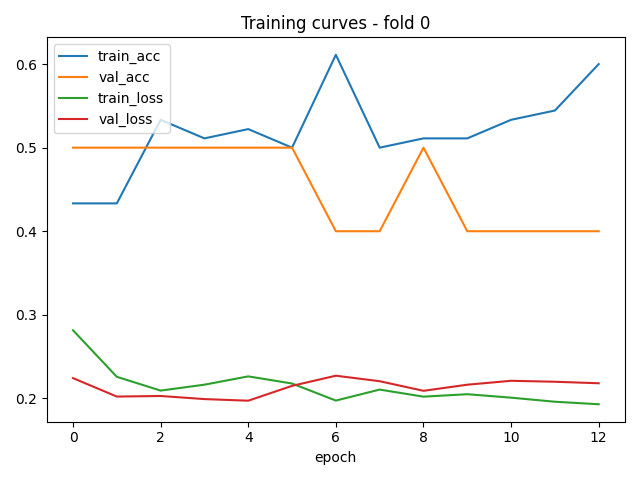

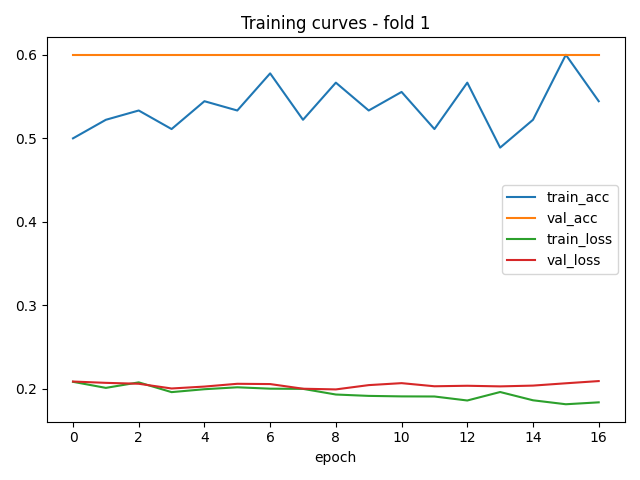

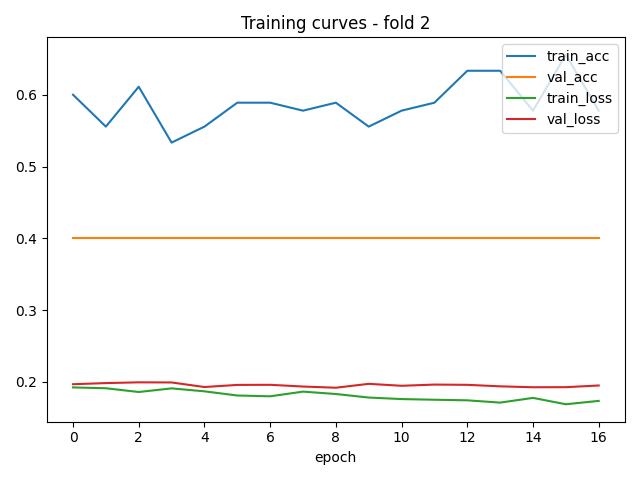

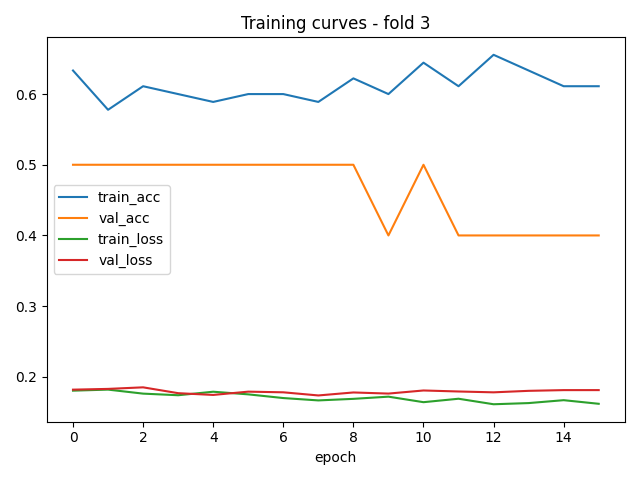

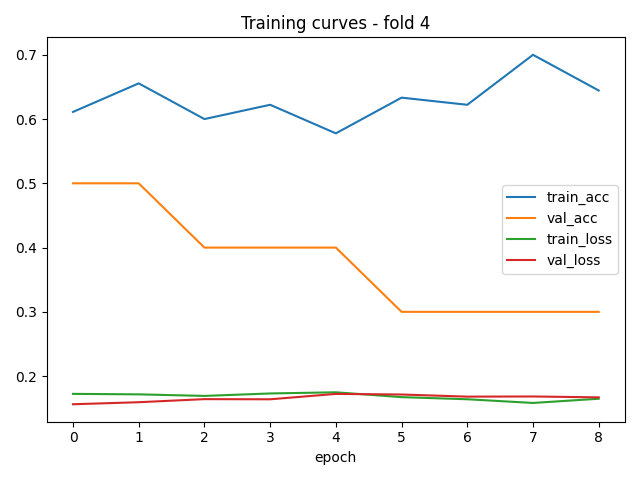

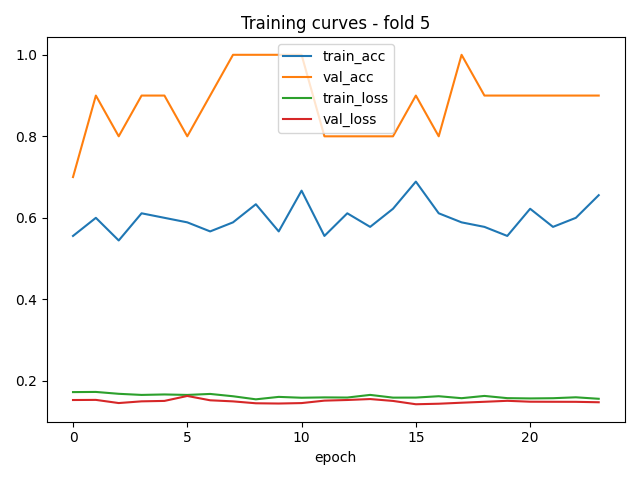

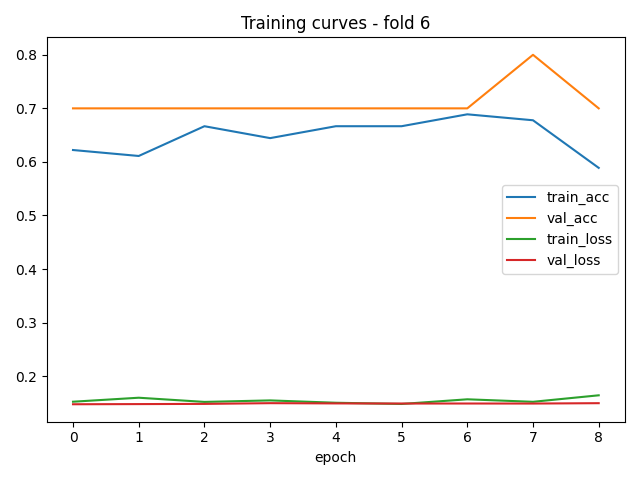

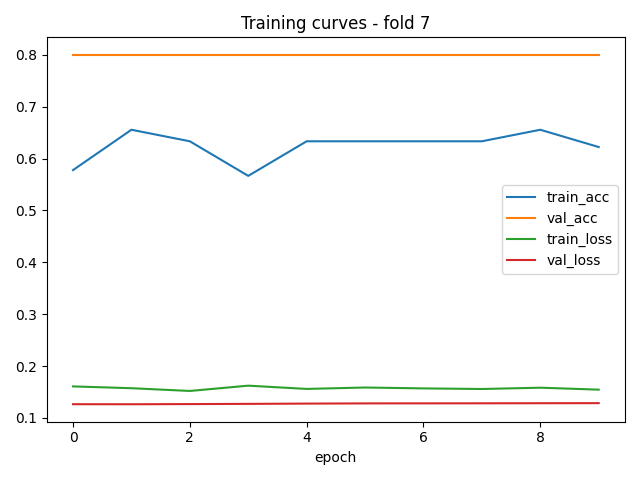

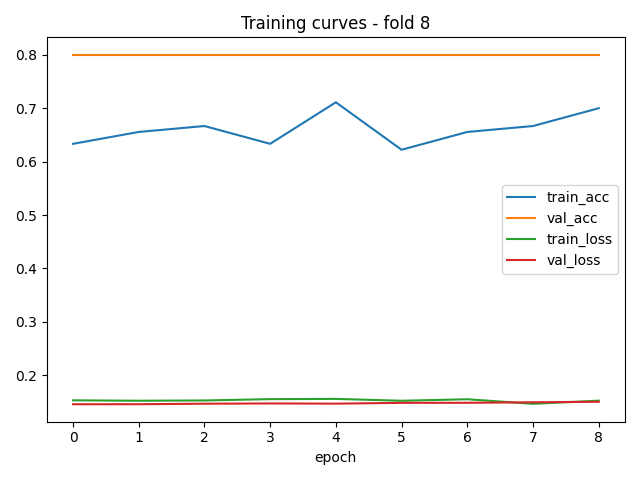

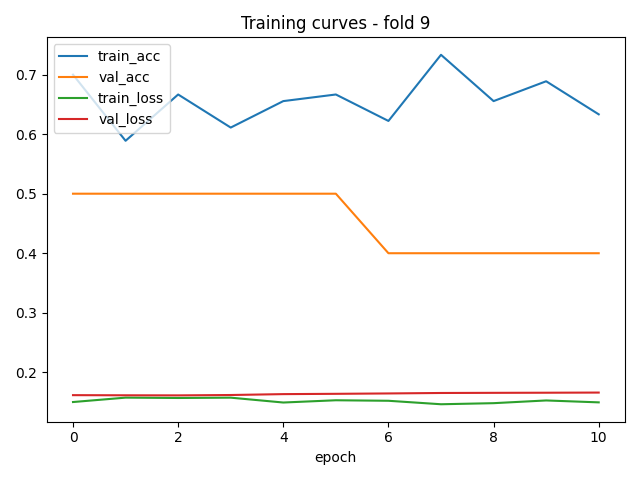

Visualization images saved to ./artifacts
Run complete. Artifacts in ./artifacts


In [11]:
# === Training loop (LOSO GroupKFold) with ensembling and threshold tuning ===
n_subjects = len(np.unique(subjects))
print('n_subjects (LOSO folds):', n_subjects)
gkf = GroupKFold(n_splits=n_subjects)
results = []
fold = 0

# for collecting overall predictions if you want aggregated analysis
all_y_true = []
all_y_pred_bin = []
all_y_pred_prob = []

# for visualization and per-fold storage
fold_records = []
histories = []

for train_idx, val_idx in gkf.split(all_keys, labels_arr, groups=subjects):
    print('\n=== Fold', fold, '===')
    train_keys = [all_keys[i] for i in train_idx]
    val_keys = [all_keys[i] for i in val_idx]

    # build datasets
    # compute class weights on training labels
    y_train = np.array([labels_user[k] for k in train_keys])
    classes = np.unique(y_train)
    cw = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight = {int(classes[i]): float(cw[i]) for i in range(len(classes))}
    print('class_weight (per-class):', class_weight)

    # per-sample weights for tf dataset
    sample_weights_train = compute_sample_weights_for_keys(train_keys, class_weight)
    ds_train = make_dataset_from_keys(train_keys, sample_weights=sample_weights_train, shuffle=True, batch_size=BATCH_SIZE, augment=True)
    ds_val = make_dataset_from_keys(val_keys, sample_weights=None, shuffle=False, batch_size=BATCH_SIZE, augment=False)

    # optional: train xgboost on aggregated features and get val preds for ensembling
    xgb_val_probs = None
    xgb_clf = None
    if ENSEMBLE_WITH_XGB:
        xgb_clf, xgb_val_probs = train_xgb_on_keys(train_keys, val_keys)

    # callbacks: checkpoint, earlystop, LR reduce, val F1 printing
    ckpt_path = os.path.join(OUT_DIR, f'fusion_fold{fold}.weights.h5')
    callbacks = [
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, save_best_only=True, monitor='val_loss'),
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    ]

    # custom callback: compute val F1 after each epoch (uses ds_val)
    class ValF1Callback(keras.callbacks.Callback):
        def __init__(self, ds_val):
            super().__init__()
            self.ds_val = ds_val

        def on_epoch_end(self, epoch, logs=None):
            y_true = []
            y_pred = []
            for (eeg_b, video_b, demo_b), (label_b, _) in self.ds_val:
                preds, _ = self.model.predict_on_batch((eeg_b, video_b, demo_b))
                preds = preds.reshape(-1)
                y_true.extend(label_b.numpy().tolist())
                y_pred.extend(preds.tolist())
            # tune threshold on this val mini-set and report best f1
            best_t = 0.5
            best_f1 = -1
            for t in np.linspace(0.1, 0.9, 17):
                binp = [(p >= t) for p in y_pred]
                if len(set(y_true)) <= 1:
                    continue
                f1 = f1_score(y_true, binp)
                if f1 > best_f1:
                    best_f1 = f1
                    best_t = t
            print(f"  -> epoch {epoch} val_best_f1: {best_f1:.4f} at t={best_t:.2f}")

    callbacks.append(ValF1Callback(ds_val))

    # fit model. Note: we are passing datasets where sample_weights are embedded in dataset as third element if provided.
    # Keras expects (x, y, sample_weight) triples if present in the dataset.
    history = model_full.fit(ds_train, validation_data=ds_val, epochs=EPOCHS, callbacks=callbacks, verbose=2)
    histories.append(history.history)

    # load best weights for evaluation
    try:
        model_full.load_weights(ckpt_path)
    except Exception as e:
        print('Could not load weights from', ckpt_path, ':', e)

    # predict on validation set
    y_true = []
    y_pred_probs = []
    att_list = []
    # iterate through ds_val batches
    for (eeg_b, video_b, demo_b), (label_b, _) in ds_val:
        preds, att = model_full.predict_on_batch((eeg_b, video_b, demo_b))
        preds = preds.reshape(-1)
        y_true.extend(label_b.numpy().tolist())
        y_pred_probs.extend(preds.tolist())
        att_list.append(att)
    if len(att_list) > 0:
        att_concat = np.concatenate(att_list, axis=0)
    else:
        att_concat = np.zeros((0,3))

    # ensemble with xgboost if available
    if ENSEMBLE_WITH_XGB and xgb_val_probs is not None:
        p_xgb = xgb_val_probs
        p_fusion = np.array(y_pred_probs)
        w = XGB_ENSEMBLE_WEIGHT
        p_comb = (1.0 - w) * p_fusion + w * p_xgb
        y_pred_final_prob = p_comb
    else:
        y_pred_final_prob = np.array(y_pred_probs)

    # threshold tuning on val to pick best threshold maximizing F1
    best_t = 0.5
    best_f1 = -1
    for t in np.linspace(0.1, 0.9, 81):
        y_pred_bin = (y_pred_final_prob >= t).astype(int).tolist()
        if len(set(y_true)) <= 1:
            f1 = float('nan')
        else:
            f1 = f1_score(y_true, y_pred_bin)
        if not math.isnan(f1) and f1 > best_f1:
            best_f1 = f1
            best_t = t

    y_pred_bin = (y_pred_final_prob >= best_t).astype(int)
    f1 = f1_score(y_true, y_pred_bin) if len(set(y_true))>1 else float('nan')
    auc_score = roc_auc_score(y_true, y_pred_final_prob) if len(set(y_true))>1 else float('nan')
    acc = accuracy_score(y_true, y_pred_bin)
    prec = precision_score(y_true, y_pred_bin, zero_division=0)
    rec = recall_score(y_true, y_pred_bin, zero_division=0)
    print(f'Fold {fold} — BEST_THR {best_t:.3f} — F1: {f1:.4f}, AUC: {auc_score:.4f}, Acc: {acc:.4f}, P: {prec:.4f}, R: {rec:.4f}')

    results.append({'fold': fold, 'f1': f1, 'auc': auc_score, 'acc': acc, 'prec': prec, 'rec': rec, 'best_thr': best_t})
    # save attention mean for fold
    if att_concat.size:
        print('Mean attention (EEG,Video,Demo):', att_concat.mean(axis=0))

    # append for global analysis
    all_y_true.extend(y_true)
    all_y_pred_bin.extend(y_pred_bin.tolist())
    all_y_pred_prob.extend(y_pred_final_prob.tolist())

    # keep per-fold record for visualization
    fold_records.append({'fold': fold, 'y_true': np.array(y_true), 'y_prob': np.array(y_pred_final_prob), 'y_pred_bin': np.array(y_pred_bin), 'best_t': best_t, 'att': att_concat})

    fold += 1
    # clear session to reduce memory
    tf.keras.backend.clear_session()

# summarize results
res_df = pd.DataFrame(results)
print(res_df.describe())
res_df.to_csv(os.path.join(OUT_DIR, 'fusion_cv_results_enhanced.csv'), index=False)
# save final weights (not ensemble weights)
try:
    model_full.save_weights(os.path.join(OUT_DIR, 'fusion_final_enhanced.weights.h5'))
    print('Saved final fusion weights.')
except Exception as e:
    print('Could not save final weights:', e)

# overall metrics across folds (aggregate)
if len(all_y_true) > 0:
    print('Overall aggregated metrics:')
    try:
        overall_f1 = f1_score(all_y_true, all_y_pred_bin)
        overall_auc = roc_auc_score(all_y_true, all_y_pred_prob)
        overall_acc = accuracy_score(all_y_true, all_y_pred_bin)
        print('F1:', overall_f1, 'AUC:', overall_auc, 'Acc:', overall_acc)
    except Exception as e:
        print('Could not compute aggregated metrics:', e)

# helper to plot and save confusion matrix
def plot_confusion_matrix(cm, classes, title, outpath):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(outpath)
    display(Image(outpath))
    plt.close()

# Per-fold ROC and PR curves + Confusion matrices
for rec in fold_records:
    fold = rec['fold']
    y_true = rec['y_true']
    y_prob = rec['y_prob']
    y_pred = rec['y_pred_bin']

    if len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1],'--')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f'Fold {fold} ROC curve (AUC = {roc_auc:.3f})')
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f'roc_fold_{fold}.png'))
        display(Image(os.path.join(OUT_DIR, f'roc_fold_{fold}.png')))
        plt.close()

        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall, precision)
        plt.figure()
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Fold {fold} PR curve (AUPRC = {pr_auc:.3f})')
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f'pr_fold_{fold}.png'))
        display(Image(os.path.join(OUT_DIR, f'pr_fold_{fold}.png')))
        plt.close()

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, classes=['0','1'], title=f'Confusion matrix - fold {fold}', outpath=os.path.join(OUT_DIR, f'cm_fold_{fold}.png'))

# Aggregate ROC/PR curves
if len(all_y_true) > 0 and len(set(all_y_true))>1:
    fpr, tpr, _ = roc_curve(all_y_true, all_y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Aggregate ROC curve (AUC = {roc_auc:.3f})')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'roc_aggregate.png'))
    display(Image(os.path.join(OUT_DIR, 'roc_aggregate.png')))
    plt.close()

    precision, recall, _ = precision_recall_curve(all_y_true, all_y_pred_prob)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Aggregate PR curve (AUPRC = {pr_auc:.3f})')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'pr_aggregate.png'))
    display(Image(os.path.join(OUT_DIR, 'pr_aggregate.png')))
    plt.close()

# Aggregate confusion matrix
if len(all_y_true) > 0:
    cm_all = confusion_matrix(all_y_true, all_y_pred_bin, labels=[0,1])
    plot_confusion_matrix(cm_all, classes=['0','1'], title='Aggregate confusion matrix', outpath=os.path.join(OUT_DIR, 'cm_aggregate.png'))

# Training curves (loss & accuracy) per fold saved into a single figure per metric
for i, h in enumerate(histories):
    # Keras metric name may be 'prob_accuracy' or 'accuracy' depending on TF version
    acc = h.get('prob_accuracy', h.get('accuracy', None))
    val_acc = h.get('val_prob_accuracy', h.get('val_accuracy', None))
    loss = h.get('loss', None)
    val_loss = h.get('val_loss', None)

    if acc is not None or loss is not None:
        plt.figure()
        if acc is not None:
            plt.plot(acc, label='train_acc')
        if val_acc is not None:
            plt.plot(val_acc, label='val_acc')
        if loss is not None:
            plt.plot(loss, label='train_loss')
        if val_loss is not None:
            plt.plot(val_loss, label='val_loss')
        plt.legend()
        plt.title(f'Training curves - fold {i}')
        plt.xlabel('epoch')
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f'training_curves_fold_{i}.png'))
        display(Image(os.path.join(OUT_DIR, f'training_curves_fold_{i}.png')))
        plt.close()

# Save key artifacts for report
np.save(os.path.join(OUT_DIR, 'all_y_true.npy'), np.array(all_y_true))
np.save(os.path.join(OUT_DIR, 'all_y_pred_prob.npy'), np.array(all_y_pred_prob))
np.save(os.path.join(OUT_DIR, 'all_y_pred_bin.npy'), np.array(all_y_pred_bin))

# Save a small report CSV summarizing fold metrics
pd.DataFrame(results).to_csv(os.path.join(OUT_DIR, 'fold_metrics_summary.csv'), index=False)

print('Visualization images saved to', OUT_DIR)
print('Run complete. Artifacts in', OUT_DIR)